In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.io import loadmat

In [6]:
def load_texture(path: str):
  if path.endswith('.mat'):
    data = loadmat(path)

    imgs = [data['imgs'][:,:,i] for i in range(data['imgs'].shape[2])]
    img = imgs[5]
    img = (img - img.min())/(img.max() - img.min())*255
    img = Image.fromarray(img).convert('L')

  elif path.endswith('.png') or path.endswith('.jpg'):
    img = Image.open(path)

  return img

In [7]:
PATH = "../Textures/Original/"

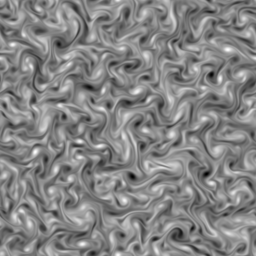

In [8]:
load_texture(PATH + "ns_randn4_train_N256.mat")

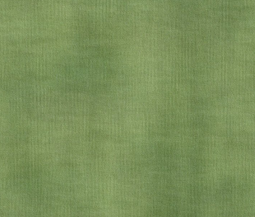

In [9]:
load_texture(PATH + "microTexture.png")

In [10]:
def generate_random_phase(shape):
    """ Génère une phase aléatoire uniforme symétrique dans (−π, π] """
    M, N = shape
    phase = np.random.uniform(-np.pi, np.pi, (M, N))

    # Odd
    for m in range(M//2,M):
      for n in range (N):
        phase[(M-m)%M, (N-n)%N] = phase[m,n]

    # Cas particuliers
    for m, n in [(0, 0), (M//2, 0), (0, N//2), (M//2, N//2)]:
        phase[m, n] = np.random.choice([0, np.pi])

    return phase

In [11]:
def rpn_texture(img):
    # Charger l’image et convertir en tableau [0,1]
    color = (img.mode != 'L')
    if color :
      img = np.asarray(img, dtype=np.float32)/255.0
    else :
      img = np.asarray(img, dtype=np.float32)

    shape = img.shape


    # FFT de chaque canal
    if color:

      fft_r = np.fft.fft2(img[:, :, 0])
      fft_g = np.fft.fft2(img[:, :, 1])
      fft_b = np.fft.fft2(img[:, :, 2])

    else:
      fft = np.fft.fft2(img)

    # Générer une phase aléatoire
    phase = generate_random_phase(shape[:2])
    exp_phase = np.exp(1j * phase)

    # Appliquer la même phase à chaque canal (préserve les couleurs)
    if color:
      synth_r = np.fft.ifft2(np.abs(fft_r) * exp_phase)
      synth_g = np.fft.ifft2(np.abs(fft_g) * exp_phase)
      synth_b = np.fft.ifft2(np.abs(fft_b) * exp_phase)

      # Empiler les canaux et normaliser
      synth = np.abs(np.stack([synth_r, synth_g, synth_b], axis=-1).real)
    else :
      synth = np.abs(np.fft.ifft2(np.abs(fft) * exp_phase).real)


    return img, synth

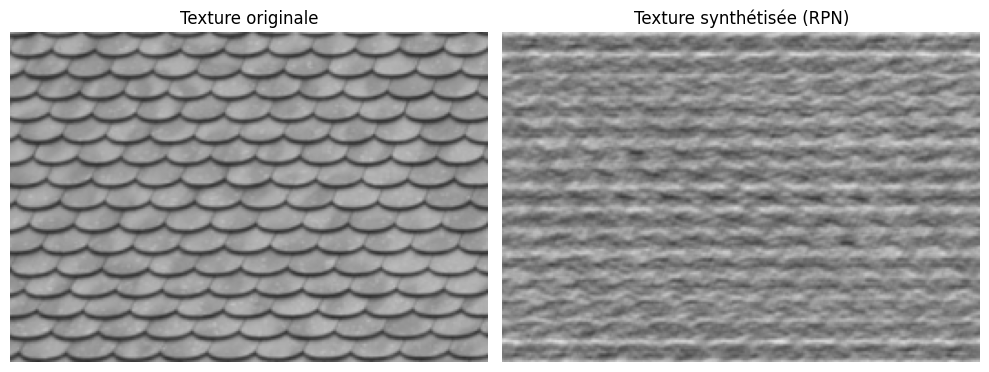

In [24]:
img_name = "ns_randn4_train_N256.mat"
img_name = "microTexture.png"
img_name = "contrastedTexture.png"

img = load_texture(PATH + img_name)

original, rpn_result = rpn_texture(img)


cmap = 'gray' if img.mode == 'L' else None

# Affichage
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(original, cmap=cmap)
axs[0].set_title("Texture originale")
axs[0].axis('off')

axs[1].imshow(rpn_result,cmap=cmap)
axs[1].set_title("Texture synthétisée (RPN)")
axs[1].axis('off')

plt.tight_layout()
# plt.show()
plt.savefig("../Textures/Generated/RPN/" + img_name)

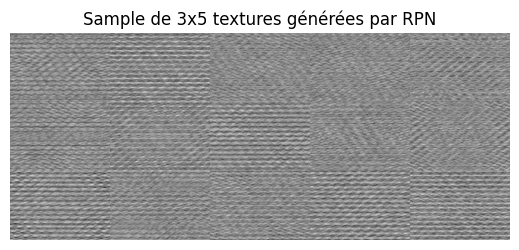

In [22]:
num_samples = 15
num_col = 5
num_row = num_samples // num_col
samples = [rpn_texture(img)[1] for _ in range(num_samples)]

# Obtenir la taille d'une image
if img.mode == 'L' :
  h, w = samples[0].shape
  # Créer une image vide de la taille de la mosaïque
  mosaic = np.zeros((num_row * h, num_col * w), dtype=np.float32)
else :
  h, w, c = samples[0].shape
  # Créer une image vide de la taille de la mosaïque
  mosaic = np.zeros((num_row * h, num_col * w, c), dtype=np.float32)


# Remplir la mosaïque avec les images
for idx, sample in enumerate(samples):
    i = idx // num_col
    j = idx % num_col
    if img.mode == 'L' :
      mosaic[i*h:(i+1)*h, j*w:(j+1)*w] = sample
    else:
      mosaic[i*h:(i+1)*h, j*w:(j+1)*w, :] = sample

# Affichage de l'image mosaïque finale
plt.figure(figsize=(num_col, num_row))
plt.imshow(mosaic, cmap=cmap)
plt.axis('off')
plt.tight_layout(pad=0)
plt.title(f'Sample de {num_row}x{num_col} textures générées par RPN')
plt.show()
